In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
from six.moves import cPickle as pickle
%matplotlib inline

/home/josh/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [24]:
#pickle_file = 'train.pickle'
'''
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X_1 = save['data']
    train_outcome_1 = save['outcome']
    del save  # hint to help gc free up memory
'''
    
pickle_file = 'train2.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X_0 = save['data']
    train_outcome_0 = save['outcome']
    del save  # hint to help gc free up memory
    
'''
pickle_file = 'test.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_X_1 = save['data']
    test_outcome_1 = save['outcome']
    del save  # hint to help gc free up memory
    
'''

pickle_file = 'test2.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_X_0 = save['data']
    test_outcome_0 = save['outcome']
    del save  # hint to help gc free up memory

In [25]:
train_X_0.shape

(33402, 64, 64, 3)

In [26]:
train_label = train_outcome_0['label']

for i in range(7):
    pickle_file = 'extra_crop_' + str(i) + '.pickle'
    
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        extra_X_tmp = save['data']
        extra_outcome_tmp = save['outcome']
        del save  # hint to help gc free up memory
        
        train_X_0 = np.vstack((train_X_0 ,extra_X_tmp ))
        train_label = train_label + extra_outcome_tmp['label']
        print '{}th extra incorperated into training data'.format(i)

0th extra incorperated into training data
1th extra incorperated into training data
2th extra incorperated into training data
3th extra incorperated into training data
4th extra incorperated into training data
5th extra incorperated into training data
6th extra incorperated into training data


define a batch generator

In [27]:


class BatchGenerator(object):
    
    def __init__(self, x_image, y_labels, batch_size, num_unrollings):
        self._x_image = x_image
        self._y_labels = y_labels
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        self._y_digits = self._extract_digits()
        
        
    def _extract_digits(self):
        end_digit = 10.0
        
        digits = np.ndarray(shape=(
                self._num_unrollings, len(self._y_labels), int(end_digit + 1)), 
                            dtype=np.float32)
        
        for i in range(self._num_unrollings):
            digit_coding = np.asarray( [x[i] if len(x)>i else end_digit 
                                        for x in self._y_labels])
            digit_coding = (
                np.arange(end_digit+1) == digit_coding[:,None]).astype(np.float32)
            digits[i,:,:] = digit_coding
        
        return digits
    
    def next_batch(self):
        idx = np.random.choice(self._x_image.shape[0],self._batch_size)
        batch_x = self._x_image[idx,:,:,:]
        batch_y = self._y_digits[:,idx,:]
        
        return batch_x, batch_y

# sample a small data set

In [28]:
num_unrollings=5

image_size = train_X_0.shape[1]
num_channels = train_X_0.shape[3]
batch_size = 200
val_size = 200
test_size = 50
reg = 0.0001

RNN_num_nodes = 1024
CNN_num_nodes = 1024

#11 collums for each digits, i.e., 0,1,...,9, and a ending ch <END>
vocabulary_size = 11


train_X = train_X_0


val_label = test_outcome_0['label']
val_X = test_X_0


train_batches = BatchGenerator(train_X, 
                                    train_label,
                                    batch_size, num_unrollings)

test_batches = BatchGenerator(val_X, 
                                    val_label,
                                    val_size, num_unrollings)

In [29]:
batch_x, batch_y = train_batches.next_batch()
print batch_y.shape
print batch_x.shape

(5, 200, 11)
(200, 64, 64, 3)


# start a tensorflow session

In [30]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def max_pool_2x2_same(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')

In [31]:
# this is a simpler version of Tensorflow's 'official' version. See:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L102
# http://r2rt.com/implementing-batch-normalization-in-tensorflow.html
def batch_norm_wrapper(inputs, is_training, decay = 0.999, epsilon = 1e-3):

    scale = tf.Variable( tf.ones(inputs.get_shape()[-1]) )
    beta = tf.Variable(tf.zeros(inputs.get_shape()[-1]))
    pop_mean = tf.Variable(tf.zeros(inputs.get_shape()[-1]), trainable=False)
    pop_var = tf.Variable(tf.ones(inputs.get_shape()[-1]), trainable=False)

    if is_training:
        #for conv layer, use global normalization
        batch_mean, batch_var = tf.nn.moments(inputs,[0,1,2])
        #print pop_mean.get_shape()
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)
    
    

def batch_norm_wrapper_simple(inputs, is_training, decay = 0.999, epsilon = 1e-3):

    scale = tf.Variable( tf.ones(inputs.get_shape()[-1]) )
    beta = tf.Variable(tf.zeros(inputs.get_shape()[-1]))
    pop_mean = tf.Variable(tf.zeros(inputs.get_shape()[-1]), trainable=False)
    pop_var = tf.Variable(tf.ones(inputs.get_shape()[-1]), trainable=False)

    if is_training:
        #for conv layer, use global normalization
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        #print pop_mean.get_shape()
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)

# Construct CNN

In [36]:
def build_graph(is_training):
    
    # shape = [None, ...], the None element of the shape corresponds to a variable-sized dimension.
    x_image = tf.placeholder(tf.float32, shape=[None, image_size, image_size, num_channels])
    

    #first layer
    W_conv1 = weight_variable([5, 5, num_channels, 32])
    b_conv1 = bias_variable([32])
    
    z_conv1 = conv2d(x_image, W_conv1) + b_conv1
    z_conv1_BN = batch_norm_wrapper(z_conv1, is_training)
    h_conv1 = tf.nn.relu(z_conv1_BN)
    
    h_pool1 = max_pool_2x2(h_conv1)
    

    #second layer
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    
    z_conv2 = conv2d(h_pool1, W_conv2) + b_conv2
    z_conv2_BN = batch_norm_wrapper(z_conv2, is_training)
    h_conv2 = tf.nn.relu( z_conv2_BN )
    
    h_pool2 = max_pool_2x2_same(h_conv2)
    
    #third layer
    W_conv3 = weight_variable([5, 5, 64, 128])
    b_conv3 = bias_variable([128])

    z_conv3 = conv2d(h_pool2, W_conv3) + b_conv3
    z_conv3_BN = batch_norm_wrapper(z_conv3, is_training)
    h_conv3 = tf.nn.relu( z_conv3_BN )

    h_pool3 = max_pool_2x2(h_conv3)
    
    #fourth layer    
    W_conv4 = weight_variable([5, 5, 128, 160])
    b_conv4 = bias_variable([160])

    z_conv4 = conv2d(h_pool3, W_conv4) + b_conv4
    z_conv4_BN = batch_norm_wrapper(z_conv4, is_training)
    h_conv4 = tf.nn.relu( z_conv4_BN )
    
    h_pool4 = max_pool_2x2_same(h_conv4)
    
    
    W_conv5 = weight_variable([5, 5, 160, 180])
    b_conv5 = bias_variable([180])

    z_conv5 = conv2d(h_pool4, W_conv5) + b_conv5
    z_conv5_BN = batch_norm_wrapper(z_conv5, is_training)
    h_conv5 = tf.nn.relu( z_conv5_BN )
    h_pool5 = max_pool_2x2_same(h_conv5)
    
    
    W_conv6 = weight_variable([5, 5, 180, 180])
    b_conv6 = bias_variable([180])

    z_conv6 = conv2d(h_pool5, W_conv6) + b_conv5
    z_conv6_BN = batch_norm_wrapper(z_conv6, is_training)
    h_conv6 = tf.nn.relu( z_conv6_BN )
    h_pool6 = max_pool_2x2_same(h_conv6)
    
    

    W_fc1 = weight_variable([16 * 16 * 180, 1024])
    b_fc1 = bias_variable([1024])

    h_pool6_flat = tf.reshape(h_pool6, [-1, 16*16*180])
    z_fc1 = tf.matmul(h_pool6_flat, W_fc1) + b_fc1
    z_fc1_BN = batch_norm_wrapper_simple(z_fc1, is_training)
    h_fc1 = tf.nn.relu(z_fc1_BN)
    

    # Input gate: input, previous output, and bias.
    ix = weight_variable([vocabulary_size, RNN_num_nodes])
    im = weight_variable([RNN_num_nodes, RNN_num_nodes])
    ib = bias_variable([RNN_num_nodes])

    # Forget gate: input, previous output, and bias.
    fx = weight_variable([vocabulary_size, RNN_num_nodes])
    fm = weight_variable([RNN_num_nodes, RNN_num_nodes])
    fb = bias_variable([RNN_num_nodes])

    # Memory cell: input, state and bias.                             
    cx = weight_variable([vocabulary_size, RNN_num_nodes])
    cm = weight_variable([RNN_num_nodes, RNN_num_nodes])
    cb = bias_variable([RNN_num_nodes])

    # Output gate: input, previous output, and bias.
    ox = weight_variable([vocabulary_size, RNN_num_nodes])
    om = weight_variable([RNN_num_nodes, RNN_num_nodes])
    ob = bias_variable([RNN_num_nodes])
    
    # Definition of the cell computation.
    # state is cell state, o is hidden state, i is input
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
        update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
        return output_gate * tf.tanh(state), state
    
    # placeholder for digit input and digit labels
    digits_data = []
    for _ in range(num_unrollings + 1):
        digits_data.append(
            tf.placeholder(tf.float32, shape=[None,vocabulary_size]))
        digits_inputs = digits_data[:num_unrollings]
        digits_labels = digits_data[1:]  # labels are inputs shifted by one time step.
        
    
    #connect with CNN
    
    W_CNN = weight_variable([CNN_num_nodes, RNN_num_nodes])
    b_CNN = bias_variable([RNN_num_nodes])
    
    CNN_output = tf.matmul(h_fc1, W_CNN) + b_CNN
    
    
    # Variables saving state across unrollings.
    #saved_output = tf.Variable(tf.zeros([batch_size, RNN_num_nodes]), trainable=False)
    #saved_state = tf.Variable(tf.zeros([batch_size, RNN_num_nodes]), trainable=False)
    
    output = CNN_output
    state = CNN_output
    
    # Unrolled LSTM loop.
    outputs = list()
    
    for i in digits_inputs:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)
        
        
    # Classifier weights and biases.
    w_fc_rnn = weight_variable([RNN_num_nodes, vocabulary_size])
    b_fc_rnn = bias_variable([vocabulary_size])

    # State saving across unrollings.
    with tf.control_dependencies(None):
        # Classifier.
        logits = tf.nn.xw_plus_b(tf.concat(0, outputs), w_fc_rnn, b_fc_rnn)
        
        penalty = reg * (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2)
                         + tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(W_conv4)
                         + tf.nn.l2_loss(W_conv5) + tf.nn.l2_loss(W_conv6)
                         + tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(W_CNN)
                         + tf.nn.l2_loss(ix) + tf.nn.l2_loss(im) 
                         + tf.nn.l2_loss(fx) + tf.nn.l2_loss(fm)
                         + tf.nn.l2_loss(cx) + tf.nn.l2_loss(cm)
                         + tf.nn.l2_loss(ox) + tf.nn.l2_loss(om) + tf.nn.l2_loss(w_fc_rnn)
                        )
        
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits, tf.concat(0, digits_labels))) + penalty
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
    
    # Unrolled LSTM loop for prediction
    output_pred = CNN_output
    state_pred = CNN_output
    
    outputs_pred = list()
    
    output_pred, state_pred = lstm_cell(digits_inputs[0], output_pred, state_pred)
    outputs_pred.append(output_pred)
    input_pred = tf.one_hot( tf.argmax(tf.matmul(output_pred, w_fc_rnn) + b_fc_rnn,1), vocabulary_size )
    
    for i in range(1,num_unrollings):
        output_pred, state_pred = lstm_cell(input_pred, output_pred, state_pred)
        outputs_pred.append(output_pred)
        input_pred = tf.one_hot( tf.argmax(tf.matmul(output_pred, w_fc_rnn) + b_fc_rnn,1), vocabulary_size  )
        print i
    
    #let's check the prediction accuracy for 2st digit
    correct_prediction = tf.cast( tf.equal(tf.argmax(tf.matmul(outputs_pred[0], w_fc_rnn) + b_fc_rnn,1), 
                                  tf.argmax(digits_labels[0],1)), tf.float32)
    for i in range(1,num_unrollings):
        correct_prediction = correct_prediction * tf.cast( 
            tf.equal(tf.argmax(tf.matmul(outputs_pred[i], w_fc_rnn) + b_fc_rnn,1), 
                                  tf.argmax(digits_labels[i],1)), tf.float32)

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return (x_image, digits_data), optimizer, loss, accuracy, logits, tf.train.Saver()

# Train on a small data to overfit
if overfit, then ok. If not, check bugs.

In [37]:
#Build training graph, train and save the trained model

#sess.close()
tf.reset_default_graph()

( (x_image, digits_data), optimizer, loss, accuracy, logits, saver) = build_graph(is_training=True)

num_steps = 1500
summary_frequency = 20

Ts_acc, Tr_acc = [], []

mean_loss = 0
mean_accuracy = 0


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for step in range(num_steps):
        
        batch_x, batch_y = train_batches.next_batch()
    
        feed_dict = dict()
        feed_dict[x_image] = batch_x
    
        feed_dict[digits_data[0]] = np.zeros([batch_y.shape[1],batch_y.shape[2]])
    
        for i in range(num_unrollings):
            feed_dict[digits_data[i+1]] = batch_y[i]
            
        _, l = sess.run(
            [optimizer, loss], feed_dict=feed_dict)
        
        #now print something
        if step % summary_frequency == 0:
            
            train_accuracy = accuracy.eval(feed_dict=feed_dict)
            Tr_acc.append(train_accuracy)
            
            print("step %d, training accuracy %g"%(step, train_accuracy))
            
            ts_bt = test_batches.next_batch()
            
            feed_dict = dict()
            feed_dict[x_image] = ts_bt[0]
    
            feed_dict[digits_data[0]] = np.zeros([ts_bt[1].shape[1],ts_bt[1].shape[2]])
    
            for i in range(num_unrollings):
                feed_dict[digits_data[i+1]] = ts_bt[1][i]
                
            test_accuracy = accuracy.eval(feed_dict=feed_dict)
            Ts_acc.append(test_accuracy)
            
            print("step %d, validation accuracy %g"%(step, test_accuracy))
            
        
    saved_model = saver.save(sess, 'temp-cnn_rnn-save')

    
Ts_acc, Tr_acc  = ( np.array(Ts_acc), np.array(Tr_acc) )

1
2
3
4
step 0, training accuracy 0
step 0, validation accuracy 0.005
step 20, training accuracy 0.02
step 20, validation accuracy 0.05
step 40, training accuracy 0.025
step 40, validation accuracy 0.05
step 60, training accuracy 0.095
step 60, validation accuracy 0.115
step 80, training accuracy 0.285
step 80, validation accuracy 0.18
step 100, training accuracy 0.41
step 100, validation accuracy 0.345
step 120, training accuracy 0.51
step 120, validation accuracy 0.37
step 140, training accuracy 0.6
step 140, validation accuracy 0.345
step 160, training accuracy 0.675
step 160, validation accuracy 0.49
step 180, training accuracy 0.71
step 180, validation accuracy 0.485
step 200, training accuracy 0.71
step 200, validation accuracy 0.56
step 220, training accuracy 0.75
step 220, validation accuracy 0.56
step 240, training accuracy 0.785
step 240, validation accuracy 0.55
step 260, training accuracy 0.845
step 260, validation accuracy 0.595
step 280, training accuracy 0.86
step 280, v

KeyboardInterrupt: 

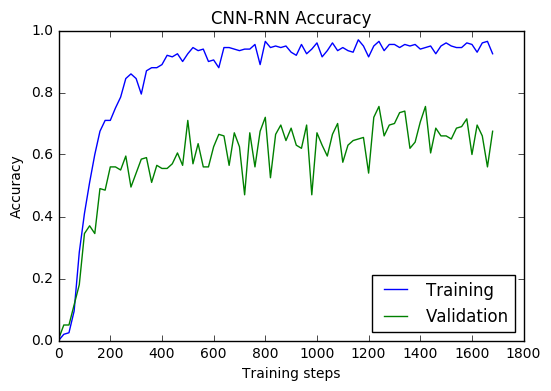

In [38]:
fig, ax = plt.subplots()

ax.plot(range(0,len(Tr_acc)*summary_frequency,summary_frequency),Tr_acc, label='Training')
ax.plot(range(0,len(Ts_acc)*summary_frequency,summary_frequency),Ts_acc, label='Validation')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])
ax.set_title('CNN-RNN Accuracy')
ax.legend(loc=4)
plt.show()